# Paper Figures: Figure 1 - Movement Analysis

This notebook generates publication-ready figures for the Bazzino & Roitman sodium appetite manuscript using data assembled by `src/assemble_all_data.py`.

**Figure 1: Behavioral Analysis** — Movement analysis showing heatmaps and summary plots for replete and deplete conditions across sodium concentrations.

In [ ]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import pathlib
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from trompy import zscore
from extract_behav_parameters import smooth_array

# Add src to path for importing local modules
sys.path.insert(0, str(Path("../src").resolve()))
from pickle_compat import enable_dill_pathlib_compat
enable_dill_pathlib_compat()

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP_DIV, HEATMAP_CMAP_UNI,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    HEATMAP_VLIM_BEHAV, YLIMS_BEHAV,
    BEHAV_SMOOTH_WINDOW, SAVE_FIGS
)
from figure_plotting import (
    smooth_array, get_heatmap_data, get_mean_snips, get_auc,
    init_heatmap_figure, init_snips_figure, make_heatmap,
    plot_snips, plot_auc_summary, save_figure, print_auc_stats,
    scale_vlim_to_data, calculate_ylims
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP_UNI  # Use shared colormap

Failed to read module file 'c:\Github\bazzino\.pixi\envs\default\Lib\re\_casefix.py' for module 're._casefix': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Github\bazzino\.pixi\envs\default\Lib\site-packages\IPython\core\extensions.py", line 62, in load_extension
    return self._load_extension(module_str)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "c:\Github\bazzino\.pixi\envs\default\Lib\site-packages\IPython\core\extensions.py", line 77, in _load_extension
    mod = import_module(module_str)
  File "c:\Github\bazzino\.pixi\envs\default\Lib\importlib\__init__.py", line 88, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1398, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1371, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1335, in _find_and_load_unlocked
ModuleNotFoundError: No module n

## Load Assembled Data

Load the complete dataset from the pickle file generated by the assembly script.

In [2]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_movement = data["snips_movement"] # not used in current figure but load for completeness
snips_angvel = data["snips_angvel"]

fits_df = data["fits_df"]
params = data.get("params", {})
metadata = data.get("metadata", {})

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"  - snips_angvel shape: {snips_angvel.shape}")
print(f"  - snips_movement shape: {snips_movement.shape}")
print(f"  - x_array columns: {x_array.columns.tolist()}")
print(f"  - Number of trials: {len(x_array)}")


Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 19)
  - snips_photo shape: (1960, 200)
  - snips_angvel shape: (1960, 200)
  - snips_movement shape: (1960, 200)
  - x_array columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'movement_mean', 'movement_std', 'angvel_mean', 'angvel_std', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_movement', 'auc_angvel', 'time_moving', 'time_above_angvel_threshold', 'time_moving_raw', 'trial_aligned']
  - Number of trials: 1960


## Figure 1: Behavioral Analysis — Movement Metrics

Analysis of behavioral responses (movement) showing heatmaps, snip time series, and summary AUC metrics across replete and deplete sodium conditions, separated by infusion type (10NaCl vs 45NaCl).

In [47]:
def zscore_to_entire_session(snips, x_array, param_name):

    mean = x_array[param_name + "_mean"].values
    std = x_array[param_name + "_std"].values
    snips_zscored = (snips - mean[:, np.newaxis]) / std[:, np.newaxis]

    return snips_zscored

In [59]:
# Smoothing angvel data and zscoring for plotting
snips_angvel_smoothed = smooth_array(snips_angvel, window_size=BEHAV_SMOOTH_WINDOW)
# snips_angvel_zscored = zscore(snips_angvel_smoothed, baseline_points=50)
# snips_angvel_zscored = zscore_to_entire_session(snips_angvel, x_array, "angvel")  # Z-score using entire session stats
# snips_angvel_smoothed = smooth_array(snips_angvel_zscored, window_size=BEHAV_SMOOTH_WINDOW)
snips_to_plot = np.array(snips_movement)  # Use smoothed and z-scored data for all subsequent analyses and plotting

# Parameters for visualization - MOVEMENT
# Use dynamic scaling based on actual data ranges (asymmetric, not symmetric)
# This ensures heatmaps use the full range of your data without artificial symmetry
vmin = np.nanpercentile(snips_movement, 5)  # 5th percentile for lower bound
vmax = np.nanpercentile(snips_movement, 95)  # 95th percentile for upper bound
vlim = (vmin, vmax)
print(f"Angular Velocity - Calculated asymmetric vlims: vmin={vmin:.4f}, vmax={vmax:.4f}")
# vlim = (-0.75, 0.75) # for zscored data
vlim = (0, 0.02)

# Calculate dynamic y-limits based on all snips data - MOVEMENT
print("\n" + "="*60)
print("CALCULATING Y-LIMITS FOR TIME SERIES PLOTS")
print("="*60)

# Get all condition/infusion combinations to compute limits
rep_10, rep_45 = get_mean_snips(snips_movement, x_array, "replete")
dep_10, dep_45 = get_mean_snips(snips_movement, x_array, "deplete")

# Calculate y-limits based on all snips with 5% padding
calc_ylims = calculate_ylims([rep_10, rep_45, dep_10, dep_45], pad_percentage=5)

print(f"  Data range (min, max): ({np.nanmin(snips_angvel):.4f}, {np.nanmax(snips_angvel):.4f})")
print(f"  Calculated y-limits: {calc_ylims}")
print("="*60 + "\n")

# Use calculated limits or override with fixed values if preferred
ylims = calc_ylims
# ylims = (-0.1, 4)


Angular Velocity - Calculated asymmetric vlims: vmin=0.0010, vmax=0.0442

CALCULATING Y-LIMITS FOR TIME SERIES PLOTS
  Data range (min, max): (0.0000, 179.3031)
  Calculated y-limits: (np.float64(-0.0013373588658733425), np.float64(0.06126457646460861))



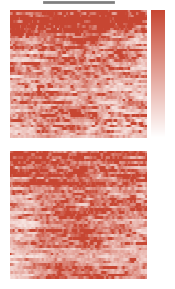

In [60]:
### 1A. Heatmaps — Replete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Replete + 10NaCl
heatmap_data_rep_10 = get_heatmap_data(snips_to_plot, x_array, "replete", "10NaCl")
replete_10_auc = get_auc(heatmap_data_rep_10)
make_heatmap(heatmap_data_rep_10, ax1, vlim, inf_bar=True, cmap=custom_cmap)

# Replete + 45NaCl
heatmap_data_rep_45 = get_heatmap_data(snips_to_plot, x_array, "replete", "45NaCl")
replete_45_auc = get_auc(heatmap_data_rep_45)
make_heatmap(heatmap_data_rep_45, ax2, vlim, cbar_ax=cbar_ax, cmap=custom_cmap)

if SAVE_FIGS:
    save_figure(f, "fig1_heatmap_angvel_replete", FIGSFOLDER)


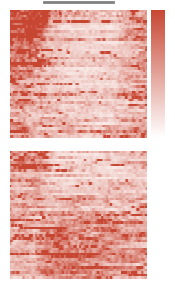

In [61]:
### 1B. Heatmaps — Deplete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Deplete + 10NaCl
heatmap_data_dep_10 = get_heatmap_data(snips_to_plot, x_array, "deplete", "10NaCl")
deplete_10_auc = get_auc(heatmap_data_dep_10)
make_heatmap(heatmap_data_dep_10, ax1, vlim, inf_bar=True, cmap=custom_cmap)

# Deplete + 45NaCl
heatmap_data_dep_45 = get_heatmap_data(snips_to_plot, x_array, "deplete", "45NaCl")
deplete_45_auc = get_auc(heatmap_data_dep_45)
make_heatmap(heatmap_data_dep_45, ax2, vlim, cbar_ax=cbar_ax, cmap=custom_cmap)

if SAVE_FIGS:
    save_figure(f, "fig1_heatmap_angvel_deplete", FIGSFOLDER)


Z-scored Angular Velocity - Symmetric vlims: vmin=-1.3290, vmax=1.3290


C:\Users\jmc010\AppData\Local\Temp\ipykernel_32888\521553057.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


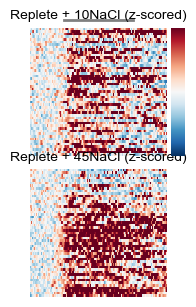

In [38]:
### Z-scored Angular Velocity (baseline normalized) - Replete Condition

# Z-score angular velocity to baseline (first 50 bins)
baseline_end = 50
snips_angvel_zscored = snips_angvel.copy()

for i in range(snips_angvel_zscored.shape[0]):
    baseline = snips_angvel_zscored[i, :baseline_end]
    baseline_mean = np.nanmean(baseline)
    baseline_std = np.nanstd(baseline)
    if baseline_std > 0:
        snips_angvel_zscored[i, :] = (snips_angvel_zscored[i, :] - baseline_mean) / baseline_std
    else:
        snips_angvel_zscored[i, :] = 0

# Calculate symmetric vlims for z-scored data
vmin_zscored = np.nanpercentile(snips_angvel_zscored, 15)
vmax_zscored = np.nanpercentile(snips_angvel_zscored, 85)
# Make symmetric around zero
vmax_zscored = max(abs(vmin_zscored), abs(vmax_zscored))
vmin_zscored = -vmax_zscored
vlim_zscored = (vmin_zscored, vmax_zscored)

print(f"Z-scored Angular Velocity - Symmetric vlims: vmin={vmin_zscored:.4f}, vmax={vmax_zscored:.4f}")

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Replete + 10NaCl (z-scored)
heatmap_data_rep_10_zscored = get_heatmap_data(snips_angvel_zscored, x_array, "replete", "10NaCl")
make_heatmap(heatmap_data_rep_10_zscored, ax1, vlim_zscored, inf_bar=True, cmap='RdBu_r')

# Replete + 45NaCl (z-scored)
heatmap_data_rep_45_zscored = get_heatmap_data(snips_angvel_zscored, x_array, "replete", "45NaCl")
make_heatmap(heatmap_data_rep_45_zscored, ax2, vlim_zscored, cbar_ax=cbar_ax, cmap='RdBu_r')

ax1.set_title("Replete + 10NaCl (z-scored)", fontsize=10)
ax2.set_title("Replete + 45NaCl (z-scored)", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_heatmap_angvel_zscored_replete", FIGSFOLDER)

plt.tight_layout()
plt.show()


In [ ]:
### Z-scored Angular Velocity (baseline normalized) - Deplete Condition

f, ax1, ax2, cbar_ax = init_heatmap_figure()

# Deplete + 10NaCl (z-scored)
heatmap_data_dep_10_zscored = get_heatmap_data(snips_movement, x_array, "deplete", "10NaCl")
make_heatmap(heatmap_data_dep_10_zscored, ax1, vlim_zscored, inf_bar=True, cmap='RdBu_r')

# Deplete + 45NaCl (z-scored)
heatmap_data_dep_45_zscored = get_heatmap_data(snips_angvel_zscored, x_array, "deplete", "45NaCl")
make_heatmap(heatmap_data_dep_45_zscored, ax2, vlim_zscored, cbar_ax=cbar_ax, cmap='RdBu_r')

ax1.set_title("Deplete + 10NaCl (z-scored)", fontsize=10)
ax2.set_title("Deplete + 45NaCl (z-scored)", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_heatmap_angvel_zscored_deplete", FIGSFOLDER)

plt.tight_layout()
plt.show()


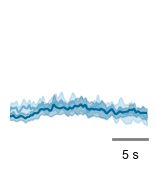

In [62]:
### 1C. Time Series Snips — Replete Condition

# Get animal-averaged snips for replete
snips_rep_10, snips_rep_45 = get_mean_snips(snips_to_plot, x_array, "replete")

f, ax = init_snips_figure()
plot_snips(snips_rep_10, snips_rep_45, ax, colors[0], colors[1], ylims)

if SAVE_FIGS:
    save_figure(f, "fig1_snips_angvel_replete", FIGSFOLDER)


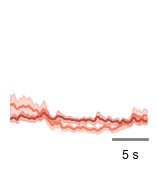

In [63]:
### 1D. Time Series Snips — Deplete Condition

# Get animal-averaged snips for deplete
snips_dep_10, snips_dep_45 = get_mean_snips(snips_to_plot, x_array, "deplete")

f, ax = init_snips_figure()
plot_snips(snips_dep_10, snips_dep_45, ax, colors[2], colors[3], ylims, scalebar=True)

if SAVE_FIGS:
    save_figure(f, "fig1_snips_movement_deplete", FIGSFOLDER)


In [ ]:
### 1E. AUC Summary — Bar Plot with Individual Data Points

# Organize AUCs by condition
replete_aucs = [get_auc(snips_rep_10), get_auc(snips_rep_45)]
deplete_aucs = [get_auc(snips_dep_10), get_auc(snips_dep_45)]
aucs = [replete_aucs, deplete_aucs]

f, ax = plot_auc_summary(aucs, colors, ylabel="Ang vel (AUC)")
f.suptitle("Ang vel — AUC Summary", fontsize=10)

if SAVE_FIGS:
    save_figure(f, "fig1_auc_movement_summary", FIGSFOLDER)

plt.tight_layout()
plt.show()

# Print summary statistics
auc_labels = [
    f"Replete + 10NaCl (n={len(snips_rep_10)})",
    f"Replete + 45NaCl (n={len(snips_rep_45)})",
    f"Deplete + 10NaCl (n={len(snips_dep_10)})",
    f"Deplete + 45NaCl (n={len(snips_dep_45)})"
]
auc_arrays = [replete_aucs[0], replete_aucs[1], deplete_aucs[0], deplete_aucs[1]]
print_auc_stats(auc_arrays, auc_labels, title="Figure 1 — Movement Summary Statistics")


Time Above Threshold Summary Statistics (per-rat means)
Replete + 10NaCl (n=10 rats)   (n=10):    0.54 ± 0.01
Replete + 45NaCl (n=10 rats)   (n=10):    0.57 ± 0.03
Deplete + 10NaCl (n=10 rats)   (n=10):    0.26 ± 0.03
Deplete + 45NaCl (n=10 rats)   (n=10):    0.44 ± 0.04


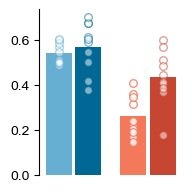

In [44]:
### Time Above Angular Velocity Threshold Summary — Bar Plot (per-rat means)

# Calculate mean time above threshold per rat, then organize by condition/infusion
# This matches the approach used for AUC where we get the mean per rat first

def get_mean_time_above_per_rat(x_array, condition, infusion):
    """Get mean time above threshold per rat for a given condition/infusion."""
    subset = x_array[(x_array['condition'] == condition) & (x_array['infusiontype'] == infusion)]
    time_above_per_rat = subset.groupby('id')['time_above_angvel_threshold'].mean().values
    return time_above_per_rat

# Get per-rat means for each condition/infusion combination
rep_10_time_above = get_mean_time_above_per_rat(x_array, "replete", "10NaCl")
rep_45_time_above = get_mean_time_above_per_rat(x_array, "replete", "45NaCl")
dep_10_time_above = get_mean_time_above_per_rat(x_array, "deplete", "10NaCl")
dep_45_time_above = get_mean_time_above_per_rat(x_array, "deplete", "45NaCl")

# Organize by condition
replete_time_above = [rep_10_time_above, rep_45_time_above]
deplete_time_above = [dep_10_time_above, dep_45_time_above]
time_above_data = [replete_time_above, deplete_time_above]

f, ax = plot_auc_summary(time_above_data, colors, ylabel="")

if SAVE_FIGS:
    save_figure(f, "fig1_time_above_threshold_summary_perrat", FIGSFOLDER)


# Print summary statistics
time_labels = [
    f"Replete + 10NaCl (n={len(rep_10_time_above)} rats)",
    f"Replete + 45NaCl (n={len(rep_45_time_above)} rats)",
    f"Deplete + 10NaCl (n={len(dep_10_time_above)} rats)",
    f"Deplete + 45NaCl (n={len(dep_45_time_above)} rats)"
]
time_arrays = [rep_10_time_above, rep_45_time_above, dep_10_time_above, dep_45_time_above]
print_auc_stats(time_arrays, time_labels, title="Time Above Threshold Summary Statistics (per-rat means)")


## Organization

This notebook generates **Figure 1 (Movement Analysis)** only. Each subsequent figure has its own dedicated notebook:

- **figure_1_paper.ipynb**: Movement analysis (current)
- **figure_2_paper.ipynb**: Photometry (dopamine) analysis  
- **figure_3_paper.ipynb**: Neural-behavioral correlation
- **figure_4_paper.ipynb**: Transition analysis
- **figure_5_paper.ipynb**: Cluster analysis

All notebooks share common settings and functions from:
- `src/figure_config.py` — Colors, paths, parameters
- `src/figure_plotting.py` — Data extraction and plotting functions

This keeps each figure focused and manageable, while reducing code duplication.

In [ ]:
# Configuration for Figure Saving
# ───────────────────────────────────────────────────────────────────────
# The SAVE_FIGS setting is loaded from figure_config.py
# Figures are saved in two formats:
#   - PDF for publication (vector format, smaller file size)
#   - PNG for presentations (raster format, high DPI for screen)
#
# All figures follow naming convention:
#   fig{number}_{description}.{pdf|png}
#
# Example:
#   fig1_heatmap_movement_replete.pdf
#   fig1_snips_movement_replete.png
# ───────────────────────────────────────────────────────────────────────

print(f"\nFigure saving is currently: {'ENABLED' if SAVE_FIGS else 'DISABLED'}")
print(f"Figure output folder: {FIGSFOLDER}")
if SAVE_FIGS:
    print("All generated figures will be saved in both PDF and PNG formats.")
else:
    print("To save figures, set SAVE_FIGS = True in src/figure_config.py")

## Figure 1 (Bonus): Movement vs Angular Velocity Comparison

Comparison of head rotation (angular velocity) with body movement to explore the relationship between these metrics across conditions.

In [ ]:
### Per-Rat Time Series: Deplete + 45NaCl (4 metrics across trials)

n_rats = len(rats)
fig, axes = plt.subplots(n_rats, 4, figsize=(14, 2.5*n_rats))

# Handle case where there's only one rat (axes would not be 2D)
if n_rats == 1:
    axes = axes.reshape(1, -1)

# Column labels
col_labels = ['AUC Movement', 'Time Moving', 'AUC Angular Vel', 'Time Above Angvel']

# Add column titles at the top
for col, label in enumerate(col_labels):
    axes[0, col].annotate(label, xy=(0.5, 1.15), xycoords='axes fraction',
                         ha='center', fontsize=11, fontweight='bold')

# Plot each rat
for row, rat in enumerate(rats):
    rat_data = x_dep45[x_dep45['id'] == rat].reset_index(drop=True)
    rat_color = rat_colors[rat]
    trial_nums = range(len(rat_data))
    
    # Column 1: AUC Movement
    axes[row, 0].plot(trial_nums, rat_data['auc_movement'], 'o-', 
                     color=rat_color, markersize=4, linewidth=1, alpha=0.7)
    axes[row, 0].set_ylabel(f'Rat {rat}', fontsize=9, fontweight='bold', labelpad=10)
    axes[row, 0].grid(True, alpha=0.3)
    axes[row, 0].tick_params(labelsize=8)
    if row == n_rats - 1:
        axes[row, 0].set_xlabel('Trial #', fontsize=9)
    
    # Column 2: Time Moving
    axes[row, 1].plot(trial_nums, rat_data['time_moving'], 'o-', 
                     color=rat_color, markersize=4, linewidth=1, alpha=0.7)
    axes[row, 1].set_ylim([0, 1])
    axes[row, 1].grid(True, alpha=0.3)
    axes[row, 1].tick_params(labelsize=8)
    if row == n_rats - 1:
        axes[row, 1].set_xlabel('Trial #', fontsize=9)
    
    # Column 3: AUC Angular Velocity (if available)
    if 'auc_angvel' in rat_data.columns:
        axes[row, 2].plot(trial_nums, rat_data['auc_angvel'], 'o-', 
                         color=rat_color, markersize=4, linewidth=1, alpha=0.7)
        axes[row, 2].grid(True, alpha=0.3)
        axes[row, 2].tick_params(labelsize=8)
        if row == n_rats - 1:
            axes[row, 2].set_xlabel('Trial #', fontsize=9)
    
    # Column 4: Time Above Angular Velocity Threshold (if available)
    if 'time_above_angvel_threshold' in rat_data.columns:
        axes[row, 3].plot(trial_nums, rat_data['time_above_angvel_threshold'], 'o-', 
                         color=rat_color, markersize=4, linewidth=1, alpha=0.7)
        axes[row, 3].set_ylim([0, 1])
        axes[row, 3].grid(True, alpha=0.3)
        axes[row, 3].tick_params(labelsize=8)
        if row == n_rats - 1:
            axes[row, 3].set_xlabel('Trial #', fontsize=9)

fig.suptitle(f'Deplete + 45NaCl: Per-Rat Metrics Across Trials (n={len(x_dep45)} trials)', 
             fontsize=12, fontweight='bold', y=0.995)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(fig, "fig1_deplete45_perrat_timeseries", FIGSFOLDER)
plt.show()

In [ ]:
### Per-Rat Angular Velocity Threshold Analysis: Deplete + 45NaCl

# Import the threshold function from assemble_all_data
from extract_behav_parameters import smooth_array

# Define different angular velocity thresholds to test
angvel_thresholds = [0.5, 1.0, 1.5, 2.0]
s, e = 50, 150  # Same bin range as used in assembly

# Prepare data: smooth angular velocity snips if not already smoothed
snips_angvel_smooth = smooth_array(snips_angvel, window_size=5)

# Pre-calculate time above threshold for all threshold values and all trials
threshold_data = {}
for thresh in angvel_thresholds:
    time_above = []
    for i in range(snips_angvel_smooth.shape[0]):
        snip = snips_angvel_smooth[i, s:e]
        proportion = len([x for x in snip if x > thresh]) / len(snip)
        time_above.append(proportion)
    threshold_data[thresh] = np.array(time_above)

# Create a dictionary of transition points by rat ID from fits_df
transition_points = {}
if fits_df is not None and len(fits_df) > 0:
    for _, row in fits_df.iterrows():
        transition_points[row['id']] = row['x0_orig']

# Create per-rat figure with one column per threshold
n_rats = len(rats)
fig, axes = plt.subplots(n_rats, len(angvel_thresholds), figsize=(12, 2.5*n_rats))

# Handle case where there's only one rat (axes would not be 2D)
if n_rats == 1:
    axes = axes.reshape(1, -1)

# Column labels with threshold values
col_labels = [f'Threshold = {t}°/frame' for t in angvel_thresholds]

# Add column titles at the top
for col, label in enumerate(col_labels):
    axes[0, col].annotate(label, xy=(0.5, 1.15), xycoords='axes fraction',
                         ha='center', fontsize=10, fontweight='bold')

# Plot each rat across all thresholds
for row, rat in enumerate(rats):
    rat_indices = x_dep45[x_dep45['id'] == rat].index.tolist()
    rat_color = rat_colors[rat]
    trial_nums = range(len(rat_indices))
    
    for col, thresh in enumerate(angvel_thresholds):
        ax = axes[row, col]
        rat_thresh_data = threshold_data[thresh][rat_indices]
        
        ax.plot(trial_nums, rat_thresh_data, 'o-', 
               color=rat_color, markersize=4, linewidth=1, alpha=0.7)
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)
        
        # Add transition point line if available for this rat
        if rat in transition_points:
            x0 = transition_points[rat]
            ax.axvline(x=x0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'x0={x0:.1f}')
            ax.legend(fontsize=7, loc='upper right')
        
        # Add rat label on first column
        if col == 0:
            ax.set_ylabel(f'Rat {rat}', fontsize=9, fontweight='bold', labelpad=10)
        
        # Add x-axis label on bottom row
        if row == n_rats - 1:
            ax.set_xlabel('Trial #', fontsize=9)

fig.suptitle(f'Deplete + 45NaCl: Per-Rat Angular Velocity Threshold Analysis (n={len(x_dep45)} trials)', 
             fontsize=12, fontweight='bold', y=0.995)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(fig, "fig1_deplete45_perrat_angvel_thresholds", FIGSFOLDER)
plt.show()

print(f"Angular velocity threshold analysis completed.")
print(f"Thresholds tested: {angvel_thresholds} degrees/frame")
print(f"Data window: bins {s}-{e}")
print(f"Number of rats: {n_rats}")
print(f"\nTransition points available for:")
for rat in rats:
    if rat in transition_points:
        print(f"  Rat {rat}: x0_orig = {transition_points[rat]:.2f} trials")
    else:
        print(f"  Rat {rat}: no transition fit available")
